# Models IV: Parameter Uncertainty & Inference
---
## Slides for reference

[Modeling Data IV (slides)](https://stat-intuitions.com/lectures/wk6/03.html)  

## Learning Goals

At the end of the previous notebook we had you fit the following model:

$$
\hat{sales}_i = \beta_0 + \beta_1*tv_i + \beta_2*radio_i + \beta_3*newspaper_i
$$

In this notebook let's examine this model in more detail to explore the following concepts that we discussed in class:
- Understanding the uncertainty of our parameter estimates and the *standard-error* output of `.summary()`
- Using *bootstrapping* to derive this uncertainty ourselves and calculate confidence intervals
- Understanding the *t* statistic and *p* value
- Using *permutation* to derive the null distribution ourselves

Your primary goal is **build an intuition for how to properly make a statistical inference** about your model parameters. Previously we discussed how we can make inferences about specific parameters by framing the question as a comparison between two models: *is the addition of this parameter worth it given the proportional reduction in error?*

Throughout this notebook we can consider a different framing: the **signal-to-noise ratio** of our estimation. 

<div align="center">
<img src="./figs/sampling.png" width="60%" alt="Figure 1">
</div>

Remember that we're looking to answer a question about something we don't have direct access to: the population. We can only collect a *sample* and then try to reason about the population from an *estimate* we make using our sample. How do we do that reasoning? By **quantifying our estimation uncertainty**. 

$$
\begin{align*}
t &= \frac{\hat{\beta}}{SE_{\hat{\beta}}} \\
&= \frac{\text{estimated value}}{\text{estimation uncertainty (error)}} \\
&= \frac{\text{signal}}{\text{noise}}
\end{align*}
$$

Conceptually, the "noise" or standard error, is a measure of the **expected average deviation** of the model’s parameter estimates $\hat{\beta}$ from the "true value" of the parameter $\beta$ in the population - the value we don't have direct access to and want to make an inference about. We can do this by quantifying our **(un)-certainty** in that estimate given our sampling error $var(e)$. 


## Data

We'll start by loading the same dataset as before and estimating the model using `ols`.

| Variable   | Description                     |
|------------|---------------------------------|
| tv     | TV ad spending in $1000 of  dollars            |
| radio     | Radio ad spending in $1000 of  dollars            |
| newspaper     | Newspaper ad spending in $1000 of  dollars            |
| sales     | Sales generated in $1000 of  dollars            |

In [1]:
import numpy as np
import polars as pl
from polars import col
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
df = pl.read_csv('./data/advertising.csv')

# Fit the model from the end of the last notebook
model = ols('sales ~ tv + radio + newspaper', data=df.to_pandas())
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Mon, 17 Feb 2025   Prob (F-statistic):           1.58e-96
Time:                        15:51:09   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.0

Let's explore the **uncertainty** associated with each parameter estimate.  
In the summary output above these are called `std err`. We can get them like this:

In [2]:
# bse = "beta standard error"
results.bse

Intercept    0.311908
tv           0.001395
radio        0.008611
newspaper    0.005871
dtype: float64

## Parametric Inference using *analytic* uncertainty estimation

In class we discussed calculating an estimate of uncertainty based upon an *analytic* formula for the standard-error of our parameter estimates - this is what `lm()` in R or `ols` in Python will automatically calculate for you and what you see in the output of `.summary()`. 

In the context of the General Linear Model we represent this uncertainty as $SE_{\hat{\beta}}$ and can calculate it using the part of the OLS formula that reflects the variance of each predictor, scaled by how wrong our model was overall:

<div align="center">
<img src="./figs/se.png" width="60%" alt="Figure 1">
</div>

Our uncertainty in $\hat{\beta}$ is based on the *variance* of a predictor and the *average error* of the model:

$$
\begin{align*}
SE_{\hat{\beta}} &= \sqrt{\sigma^2 (X^T X)^{-1}} \\
\\
\text{Where } \\
\sigma^2 &= \frac{\sum_{i=1}^n{residuals^2}}{df} \\
&= \frac{\sum_{i=1}^n{(y_i - \hat{y_i})^2}}{n-p} \\
&= MSE\text{ (mean squared error of model)} \\

\text{and } \\
n &= \text{number of observations} \\
p &= \text{number of parameters} \\

\end{align*}
$$

This formula let's us see exactly *why* "more data is better" - because it affects the **precision** of how well we can estimate our parameters! In general, our precision is approximately 

$$
\begin{align*}
&= \frac{var(e)}{\sqrt{n}} \\
\end{align*}
$$ 

The [Central Limit Theorem](https://stat-intuitions.com/lectures/wk2/03_CLT.html#why-summarization-works-the-central-limit-theorem-clt) tells us that we can assume the error of an estimate is inversely proportional to $\sqrt{n}$. In other words, the *larger* $n$, the more *precisely* we can estimate $\hat{\beta}$, so the *lower* we expect $SE_{\hat{\beta}}$ to be.

However, the process of *estimation* requires us to "fix" some of our parameters at certain values in order to estimate *other* parameters. For example, you can't calculate a *standard-deviation* without first estimating the *mean*.  

$$
\begin{align*}
&= \frac{var(e)}{\sqrt{DF_{error}}}
\end{align*}
$$ 

To take this into a account we use $DF_{error}$ in the formula - how many data point are "left-over" or "free to vary" after our estimated parameters, e.g. mean, std, intercept, slopes, etc.  

The *more* parameters we estimate, the *fewer* data points are left to freely vary, and the *worse* our precision is.  

**This is the connection to our previous approach of performing statistical inference via *model comparison***.  

The reason **why** we compare models based on an accuracy-simplicity trade-off is **because** given the same dataset, the *more* parameters we estimate, the *less* data we have to estimate them with, and the *less* precise our estimates become.

It's the bias-variance trade-off again!

<div align="center">
<img src="./figs/bias_variance.png" width="30%" alt="Figure 1">
</div>


### Breaking it down

Let's understand what this formula means by calculating each piece one-at-a-time using Python.

$$
SE_{\hat{\beta}} = \sqrt{\sigma^2 (X^T X)^{-1}} \\
$$

We'll start with $(X^TX)^{-1}$

First, we'll save our model's design matrix to a new variable `X`.  
Remember this is a matrix with the same number of columns as predictors in our model, plus an intercept

Model: $\text{sales} \sim \text{tv + radio + newspaper}$   

Design matrix has 4 columns: $intercept$, $tv$, $radio$, $newspaper$

In [3]:
X = model.exog

# print first three rows
X[:3, :]

array([[  1. , 230.1,  37.8,  69.2],
       [  1. ,  44.5,  39.3,  45.1],
       [  1. ,  17.2,  45.9,  69.3]])

### Gram Matrix $X^TX$

Now let's calculate $X^TX$, also called the $Gram$ matrix.  
Whenever you see a matrix multiplied by its own transpose you should think: **some kind of similarity matrix**.

In this case the similarity is the dot-product betnwee each pair of predictor variables:  
- $tv \& radio$
- $tv \& newspaper$
- $radio \& newspaper$

We'll visualize it using a `seaborn` heatmap, where darker colors represent higher similarity and we'll ignore the $intercept$ column which is always 1s.

*Diagonal* elements represent the un-scaled *variance within each column* of $X$; the un-scaled variance of a single predictor (e.g. $tv$).  

*Off-diagonal* elements represent the *un-scaled co-variance between each pair of columns* of $X$; the un-scaled co-variance between pairs of predictors(e.g. $tv$ and $radio$):

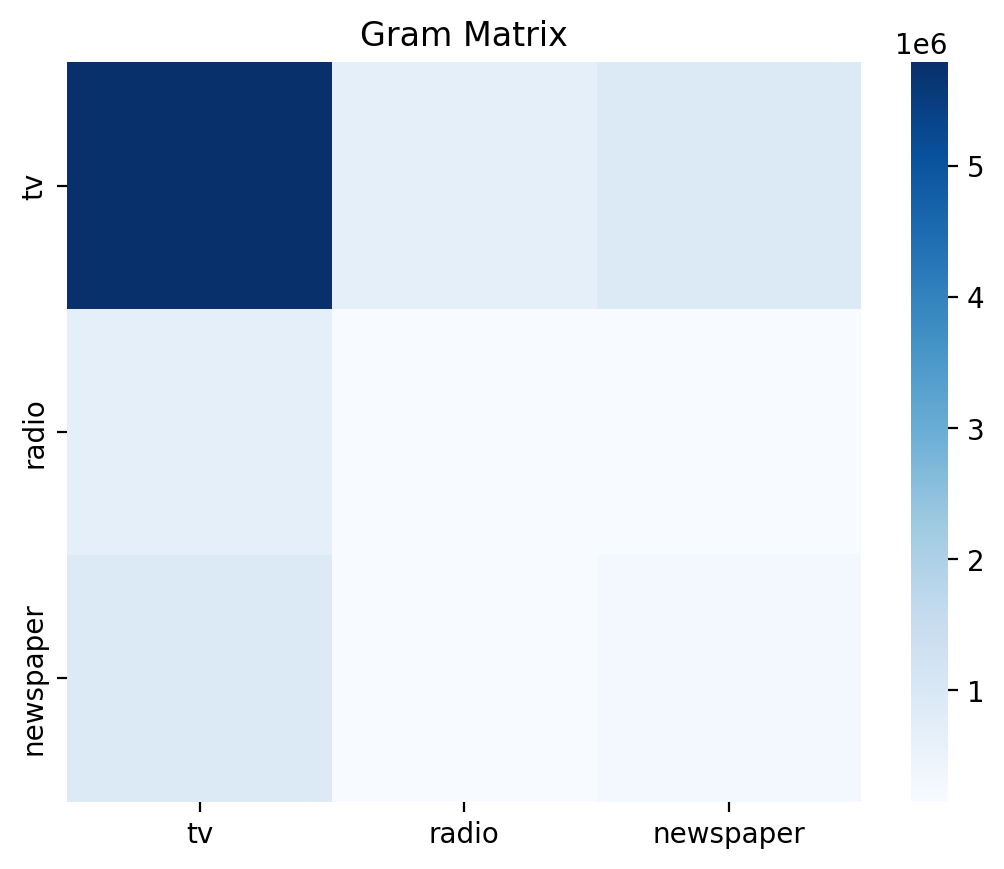

In [4]:
# short-hand for np.dot(X.T, X)
G = X.T @ X 

# Predictor names for tick labels
labels = ['tv', 'radio','newspaper']

# Ignore first row and column which is intercept
ax = sns.heatmap(G[1:, 1:], cmap='Blues', xticklabels=labels, yticklabels=labels)

ax.set_title('Gram Matrix');

Hmm it looks like $tv$ has a lot of variance compared to the other variables. Let's plot them to understand what's going on.

We'll make a histogram of each variable just to see how spread out it is:

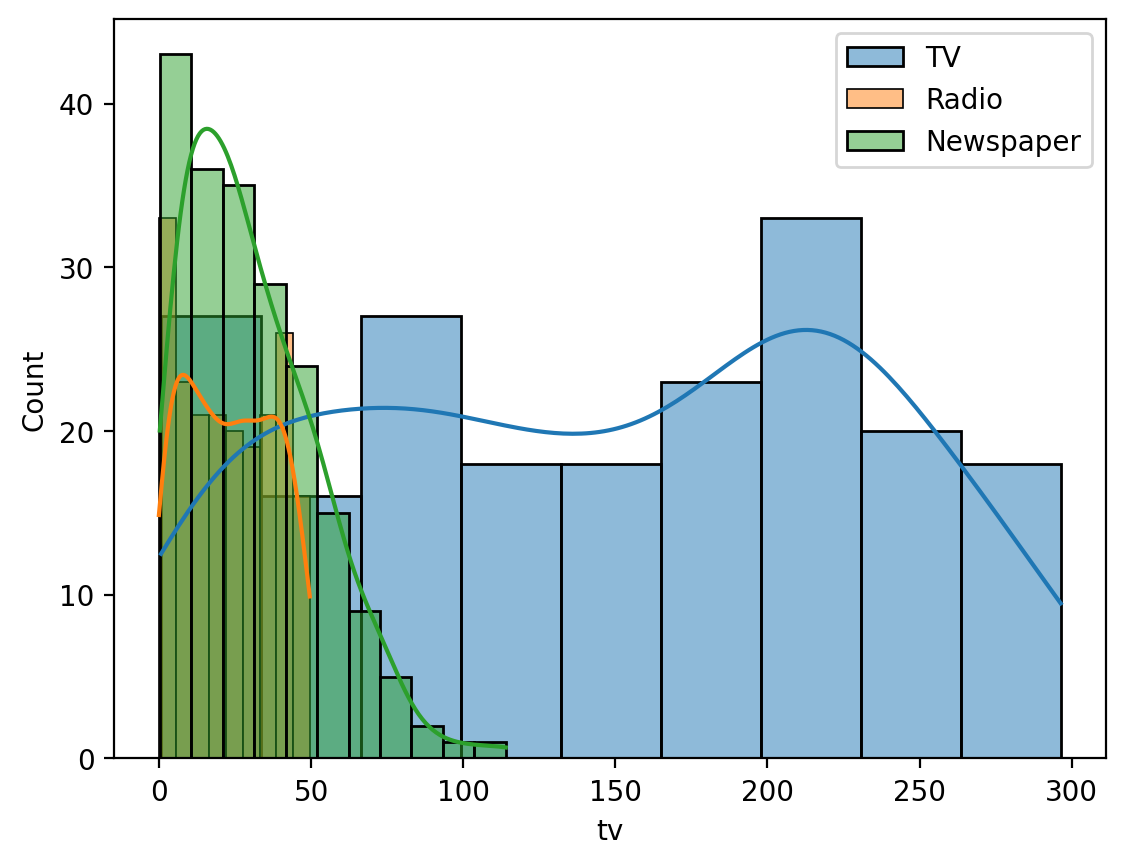

In [5]:
ax=sns.histplot(data=df, x='tv', kde=True, label='TV')
ax=sns.histplot(data=df, x='radio', kde=True, label='Radio')
ax=sns.histplot(data=df, x='newspaper', kde=True, label='Newspaper')
ax.legend();

Ah we can see that $tv$ takes on many more values than either $radio$ or $newspaper$ - its distribution is much wider, hence the higher value and darker color in the heatmap above. We'll revisit this later...

### Residual variance $\sigma^2$

To calculate the variance of the residuals we can use the `.resid` attribute of the results that `ols` calculates for us. Since it's a numpy array of values we can call `.var()` to get the variance and use `ddof=4` to account for the fact that we're estimating 4 parameters - "consuming" 4 degrees of freedom

In [6]:
# Variance of the residuals accounting for 4 estimated params
results.resid.var(ddof=4)

np.float64(2.8409452188887094)

It turns out that `ols` already calculates this for us:

In [7]:
# Variance of residuals that statsmodels already stores it for us
results.scale

np.float64(2.8409452188887103)

which confirms how we calculated it above. `ols` also stores a `.mse_resid` which is the mean-squared-error of the residuals.  

If you remember from class: *average residual variance = average model error* so it should be the same value

<div align="center">
<img src="./figs/variance.png" width="40%" alt="Figure 1">
</div>


In [8]:
# Remember resid variance = average error, so MSE is the same thing!
results.mse_resid

np.float64(2.8409452188887103)

### Calculating SE

Ok we have all the pieces to lets calculate the formula:

$$
SE_{\hat{\beta}} = \sqrt{\sigma^2 (X^T X)^{-1}} \\
$$

First, we calculate what it takes to "undo" the similarity between predictors using the matrix inverse:

In [9]:
# Calculated above
# G = X^T * X

XTXinv = np.linalg.inv(G)

Then we grab just the diagonal values - because we specifically care about the *variances* of each predictor not the co-variances between predictors.

In [10]:
diag_inv = np.diag(XTXinv)

In [11]:
# 4 for 4 predictors
diag_inv.shape

(4,)

Then we multiply by our average error to get the $\text{Var}(\beta)$

In [12]:
beta_var = results.mse_resid * diag_inv

And take the square root to finally get $SE_{\hat{\beta}} = \sqrt{\text{Var}(\hat{\beta})}$

In [13]:
beta_se = np.sqrt(beta_var)
beta_se

array([0.31190824, 0.0013949 , 0.00861123, 0.00587101])

In one fell-swoop this looks like:

In [14]:
# Altogether
np.sqrt(np.diag(results.scale * np.linalg.inv(np.dot(X.T, X)))).round(6)

array([0.311908, 0.001395, 0.008611, 0.005871])

And we can confirm against the standard-errors that `ols` calculated for us:

In [15]:
np.allclose(
    results.bse.to_numpy(),      # <- ols calculation
    beta_se                      # <- our calculation
)

True

### Analytic p-value

To make a statistical inference, we want to calculate the ratio between our *signal*, i.e. our *estimate* $\hat{\beta}$ and our *noise*, i.e. our standard-error $SE_{\hat{\beta}}$.

$$
t=\frac{\hat{\beta}}{SE_{\hat{\beta}}}
$$

The larger the $t$ the more confidence we can have in the **precision** of $\hat{\beta}$. 



In [16]:
# ols estimates
results.tvalues

Intercept     9.422288
tv           32.808624
radio        21.893496
newspaper    -0.176715
dtype: float64

In [17]:
# t = coef / se
np.allclose(
    results.tvalues,
    results.params / results.bse   # <- calculate them by hand
)

True

Now if we assume that the **sampling distribution** of this signal-to-noise-ratio $t$ looks more and more normal as the *size* of our sample grows, we can use a  *t-distribution* to look up a p-value.

Intuitively, you can think of a t-distribution as a normal distribution with **fatter tails**. In technical terms, it carries more probability mass in the extremes relative to a standard normal distribution. As our sample size grows, the degrees of freedom increase, and the tails thin out to look more and more normal - our t-statistic starts to look more like a *z-score*.

Here's a figure demonstrating that by increasing the *degrees-of-freedom* of the t-distribution and comparing it to the normal distribution:


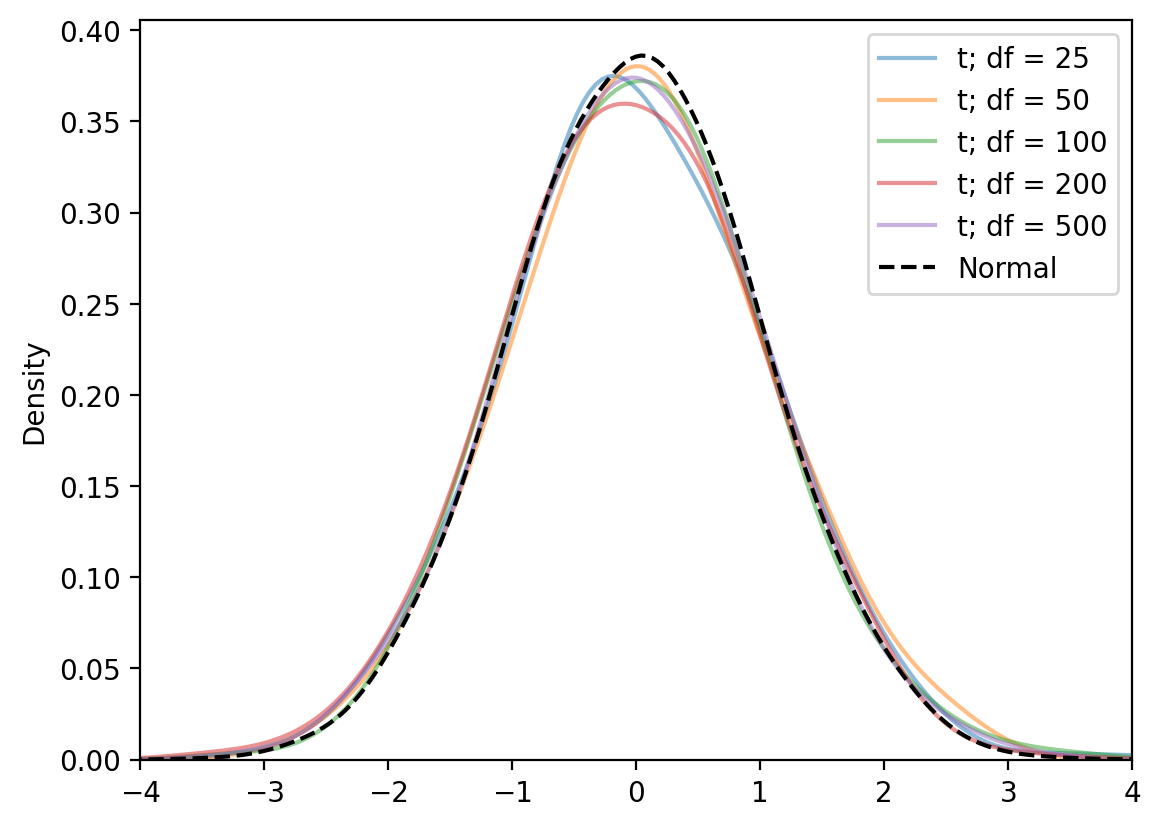

In [18]:
from scipy.stats import t

# Some mock sample sizes
sample_size = [25, 50, 100, 200, 500]

# KDE smoothing
bw_adjust = 1.5

# Loop over sample size and make plots
for sample in sample_size:
    data = t.rvs(df=sample,size=1000);
    sns.kdeplot(data, label=f"t; df = {sample}", alpha=.5, bw_adjust=bw_adjust);

# Add a normal distribution
ax = sns.kdeplot(np.random.normal(size=10000), label="Normal", alpha=1, color='black', bw_adjust=bw_adjust, ls='--');

# Customization
ax.set_xlim(-4,4)
plt.legend();

With this sampling distribution in hand, we can "look up" our p-value, which allows us to make the following inference:

**assuming no true signal exists**, how *surprised* we are to observe *this* signal-to-noise-ratio, given how many parameters we estimated overall, and the size of our sample?

In Python, we can use the cumulative distribution function of the t-distribution, to look-up the p-value using `scipy` like we did for the F-test previously:

In [24]:
# Two-sided p-value so use absolute values of t-stats
tstats = np.abs(results.tvalues.to_numpy())

# Remaining df is number of observations - number of parameters
dof = model.df_resid

# Look up the p-values using residual degrees of freedom from the model
pvals = 2 * (1 - t.cdf(tstats, df=dof))

pvals

array([0.        , 0.        , 0.        , 0.85991505])

Which is what `ols` calculated for us:

In [25]:
np.allclose(
    pvals,
    results.pvalues.to_numpy()
)

True

### Summary of parametric inference 

- **Parametric inference** is the process of using an analytic formula to **assume the shape of the sampling distribution** and "look-up" a p-value
- Our assumptions are only *guaranteed* to hold true if we have a large enough sample size
- This inference process is only valid if we haven't violated any model assumptions (e.g. no structure in our errors) 
- If we haven't violated them, then the signal-to-noise ratio of an estimate $\frac{\hat{\beta}}{SE_{\hat{\beta}}}$ will follow a t-distribution with $n-p$ degrees of freedom
- If we have, then we **should not assume the shape of the sampling distribution** - and either respecify our model/data or use non-parametric inference (next section)
- To perform parametric inference we:
  1. Estimate parameter $\hat{\beta}$
  2. Estimate our uncertainty $SE_{\hat{\beta}}$
  3. Calculate our "signal-to-noise ratio" $t = \hat{\beta} / SE_{\hat{\beta}}$
  4. Look-up our p-value: assuming no true signal (i.e. $t=0$) what is the probability of observing a value as extreme as our $t$?


## Non-parametric inference using bootstrap resampling

If that was all a bit confusing or we're not sure about violating model assumptions we can use **bootstrapping** to actually *compute* the sampling dstiributions by **resampling-with-replacement** from our data!

<div align="center">
<img src="./figs/boots.png" width="60%" alt="Figure 1">
</div>

Having a large enough sample size is still important - but it makes more intuitive sense **why**:  

If we're building *new* datasets by resampling-with-replacement from our current dataset, then a smaller dataset has far few combinations of new datasets that we can generate from it! The larger our dataset, the more combinations we have to generate, which will give us a more accurate sense of the (re)-sampling distribtion that we're building up!

Remember, what we want to know is how much $\hat{\beta}$ will change, *had we collected a different sample*. So we'll generate a new dataset, re-estimate $\hat{\beta}$, hold on to it, create *another* bootstrap sample, and repeat the process. Each time $\hat{\beta}$ will change a little bit. With enough bootstrap sample we can build-up a distribution of this variability - this **is our sampling distribution** - and the **width** of it **is the uncertainty** in our estimate!


Let's write a function to do this so that we can re-use it in the future. We want our function to take in 3 arguments:

- `results`: the output of calling `model.fit()` when we use `ols`
- `nboot`: the number of bootstraps to run
- `random_seed`: a number we can use to reproduce our random sampling

In the body of the function we want to implement a `for` loop logic to do the following:
1. Resample from `df` with replacement using the [polars `.sample()` method](https://docs.pola.rs/api/python/stable/reference/dataframe/api/polars.DataFrame.sample.html)
2. Fit a new `ols` model to the resampled data and store it's `params` (betas)
3. Repeat `nboot` times
4. At the end, use `np.std` and `np.percentile` to calculate the *width* of this distribution and the 95% confidence intervals

Finally we'll combine all the results into a new Dataframe called `boot_results`, attach it to the original `results` object that was input, and return it along with our boostrapped estimates:

In [26]:
def boot_ols(results, nboot=5000, random_seed=0):

    # A neat progress bar that replaces range()
    from tqdm import trange

    params = [] # to store the betas we estimate from each re-sampled dataset
    original_params = results.params.to_numpy() # the original betas for reference

    # For reproducibility
    np.random.seed(random_seed)

    # Start bootstrapping
    for _ in trange(nboot):
        
        # First generate a new dataset using the original dataframe in the results object
        # the .sample() method takes:
        # a fraction of the original data - in this case 1.0 aka 100% 
        # replace - whether to sample with replacement or not
        new_data = results.model.data.frame.sample(frac=1., replace=True)

        # Fit a new regression using this data and the original model formula
        boot_model = ols(results.model.formula, new_data).fit()

        # Save the estimated betas
        params.append(boot_model.params.to_numpy())
    
    # Convert the list to a numpy array for convenience
    params = np.array(params)

    # Calculate the width aka the standard-deviation across bootstraps
    std_devs = np.std(params, axis=0, ddof=results.df_model)

    # Calculate the signal-to-noise aka t-statistic using the bootstrapped SD
    tstats = original_params / std_devs 

    # Get the 95% CI limits using the bootstrapped estimates
    CI_limits = np.percentile(params, [2.5, 97.5], axis=0)

    # Combine into a DataFrame with original beta estimates
    boot_results = pl.DataFrame(CI_limits).transpose().with_columns(
        # Predictor names
        names = np.array(results.model.exog_names),
        # Bootstrapped SDs
        se=std_devs,
        # T-stats using boostrapped SDs
        tstats=tstats,
        # Original beta estimates
        estimate=original_params
        ).select(
            col('names').alias('variable'),
            col('estimate').alias('coef'),
            col('se').alias('boot-std'),
            col('tstats').alias('t'),
            col('column_0').alias('[0.025'),
            col('column_1').alias('0.975]'),
        )
    
    # Round to 5 decimal places
    boot_results = boot_results.select(
        col('variable'),
        pl.exclude("variable").round(5)
    )

    # Attach them to the result object that was passed as input
    results.boot_summary = boot_results

    # Return the results object and the bootstrapped betas
    return results, params

Let's give our function a try by passing in the `results` from our estimated model

In [27]:
results, boot_betas = boot_ols(results, nboot=1000, random_seed=1)

100%|██████████| 1000/1000 [00:01<00:00, 572.29it/s]


We now have a new `.boot_summary` attribute that contains a DataFrame with the *original* estimates in the `coef` column, and boostrapped standard-deviations which were used to compute the t-statistics and confidence intervals:

In [28]:
results.boot_summary

variable,coef,boot-std,t,[0.025,0.975]
str,f64,f64,f64,f64,f64
"""Intercept""",2.93889,0.33699,8.7209,2.25649,3.57293
"""tv""",0.04576,0.00183,24.98447,0.04215,0.04918
"""radio""",0.18853,0.01104,17.06964,0.16665,0.20919
"""newspaper""",-0.00104,0.00675,-0.15363,-0.01366,0.01226


When we compare this to the analytic standard-error, t-stats, and confidence intervals from the `ols` model you'll notice a few things that tend to be true in practice about bootstrapping:

- t-stats will be *lower*
- standard errors will be *higher*
- confidence intervals will be *wider*

In [ ]:
# slim=True simplifies the printed output a bit
print(results.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
No. Observations:                 200   F-statistic:                     570.3
Covariance Type:            nonrobust   Prob (F-statistic):           1.58e-96
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
tv             0.0458      0.001     32.809      0.000       0.043       0.049
radio          0.1885      0.009     21.893      0.000       0.172       0.206
newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


This is because boostrapping allows us to make fewer assumptions about the underlying shape of the **sampling distribution** of our parameter estimates - we're directly generating them.

The larger and more normally distributed your your original dataset, the less of a difference you'll observe between bootstrapped and analytic estimates. Here's what ours look like from the function we wrote. You'll notice that the distributions aren't perfectly symmetrical and have some additional density in the tails. 

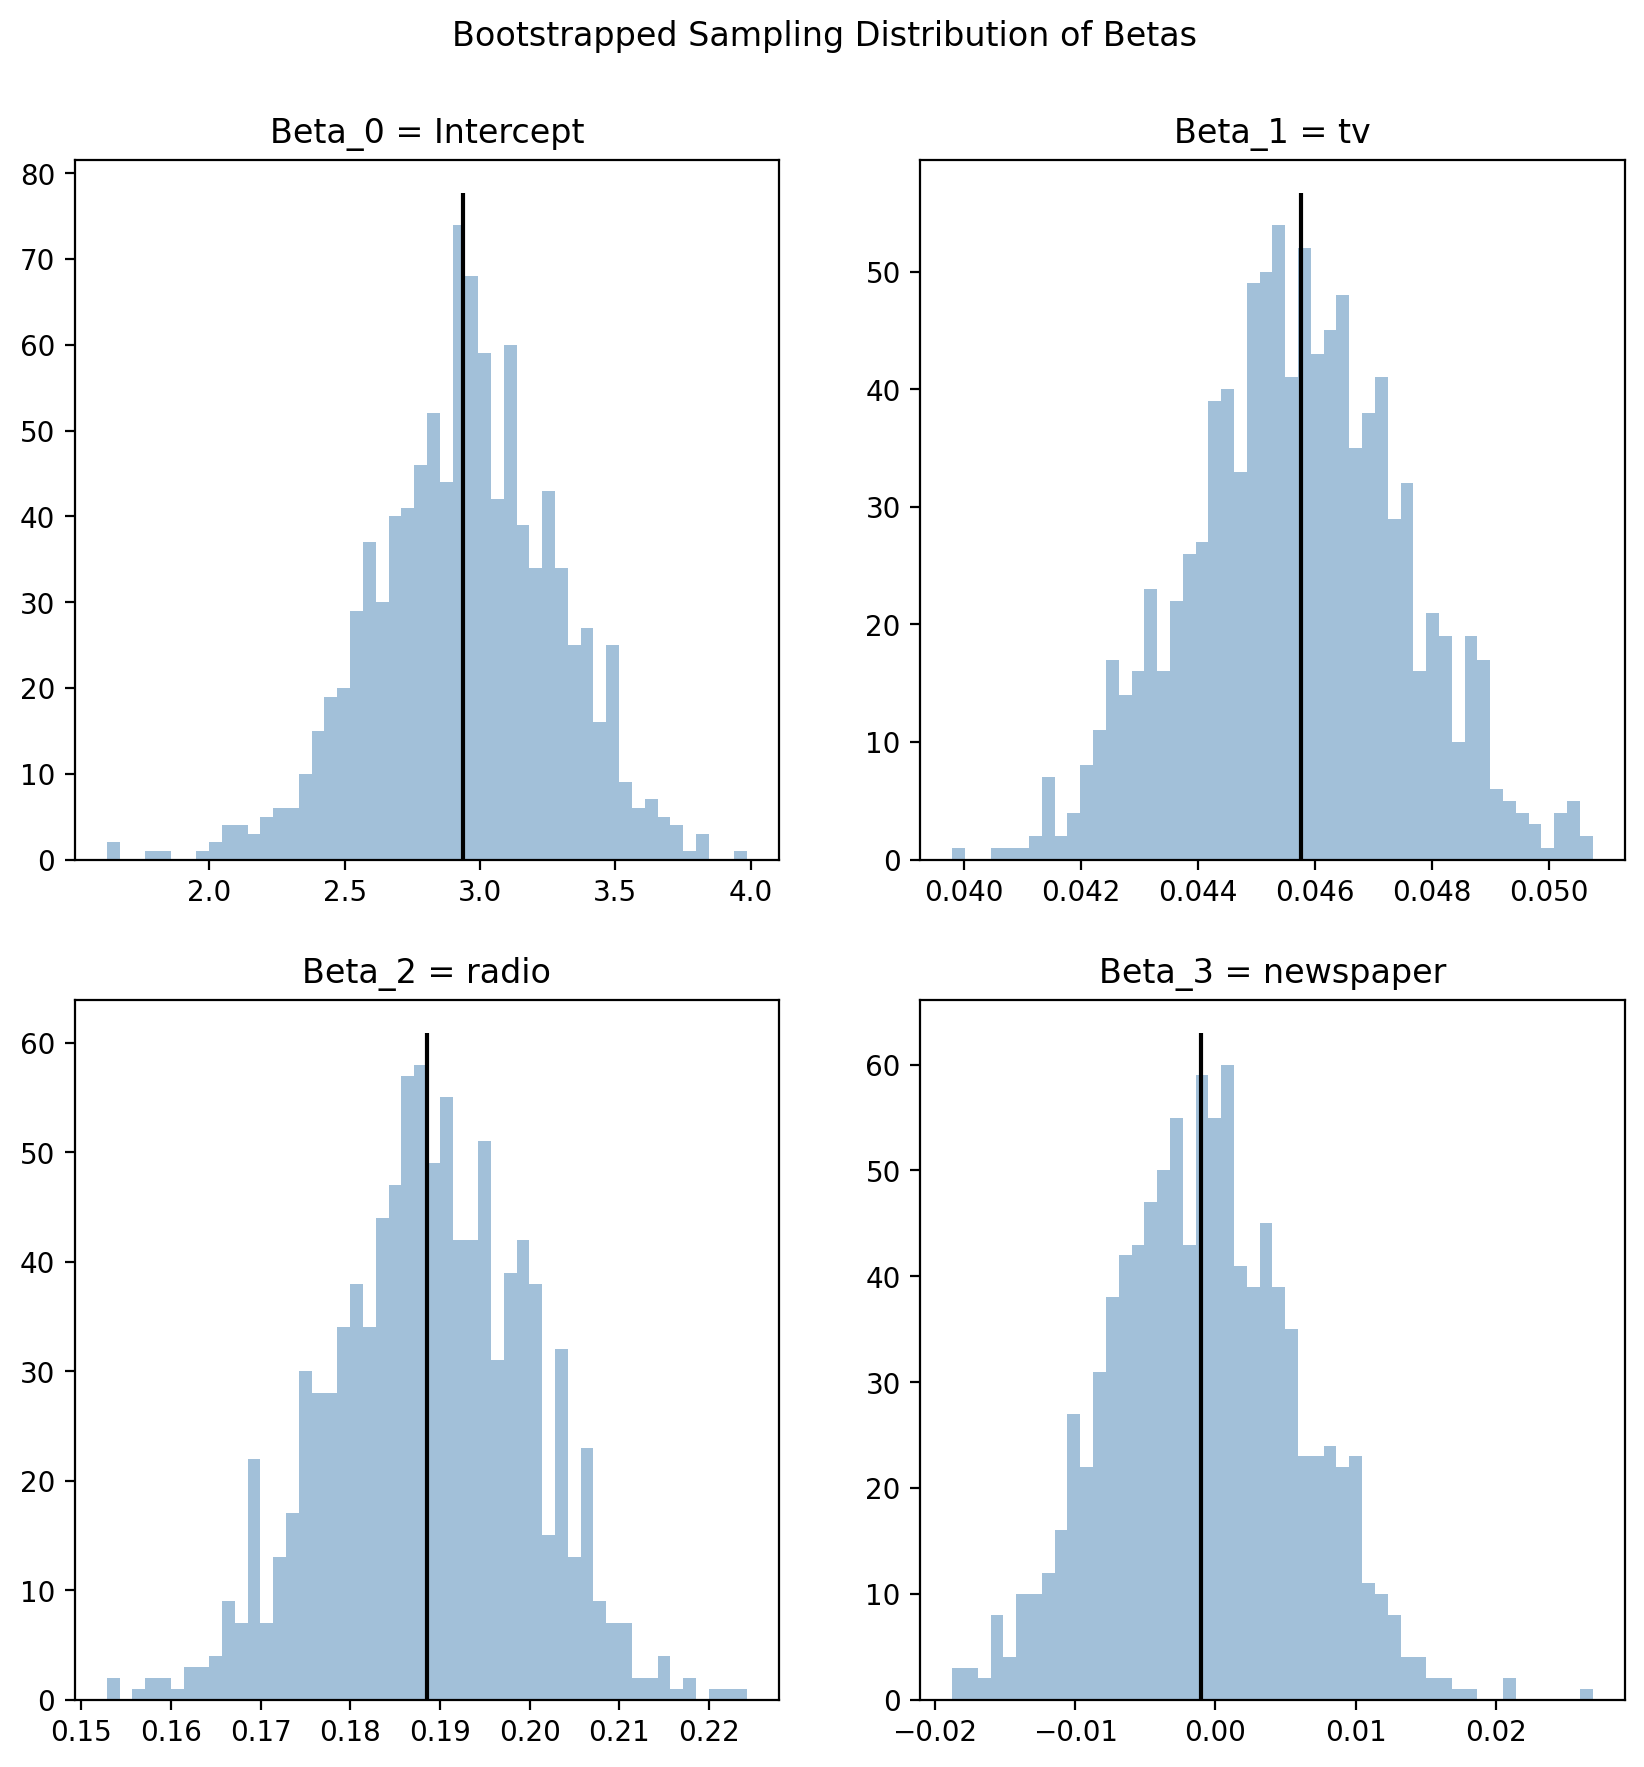

In [36]:
f, axs =plt.subplots(2,2, figsize=(10,10))
labels = ['Intercept', 'tv', 'radio', 'newspaper']

for i, ax in enumerate(axs.flat):
    _ = ax.hist(boot_betas[:,i], bins=50, color='steelblue', alpha=0.5);
    _ = ax.set_title(f"Beta_{i} = {labels[i]}");
    _ = ax.vlines(results.params.to_numpy()[i], 0, ax.get_ylim()[-1], color='black', linestyle='-');

f.suptitle("Bootstrapped Sampling Distribution of Betas", y=.95);

With these data, boostrapping happens to affords us the same statistical inference as the analytic approach.  
For example, if we look at the predictor $newspaper$, we see that the value $0$ sits within the resampled distribution of estimate for $\hat{\beta}_{newspaper}$.  
And in the summary tables above, the 95% confidence intervals contain this value. 

This leads us to the same inference as analytic p-value:  

Factoring in the uncertainty of our estimate - the value $0$ is *not* that surprising an estimate for $\hat{\beta}_{newspaper}$ - "not statistically significant"

## Non-parametric inference using permutation (shuffling)

In addition to the uncertainty of our estimates we have one more tool to perform statistical inference: we can also use resampling to **build up a null distribution**. 

Remember what a p-value fundamentally represents: the probability of observing our estimate like ours **assuming the null hypothesis is true**.  

So just like we replaced our assumption about the shape of a *sampling distribution* with bootstrapping, we can replace our assumption about the shape of a *null distribution* with **permutation**

<div align="center">
<img src="./figs/null.png" width="70%" alt="Figure 1">
</div>


Let's write another function to do this so that we can re-use it in the future. We want our function to take in 3 arguments:

- `results`: the output of calling `model.fit()` when we use `ols`
- `nperm`: the number of times to shuffle the dataset
- `random_seed`: a number we can use to reproduce our shuffling

In the body of the function we want to implement a `for` loop logic to do the following:
1. Shuffle the rows of our dependent variable column in `df` using the [polars `.sample()` method](https://docs.pola.rs/api/python/stable/reference/dataframe/api/polars.DataFrame.sample.html) which breaks its relationship to the *independent variables*
2. Fit a new `ols` model to the shuffled data and store it's `tvalues`
3. Repeat `nperm` times
4. Calculate how often the permuted t-values were greater than our original t-value

In [37]:
def perm_ols(results, nperm=5000, random_seed=0):

    # A neat progress bar that replaces range()
    from tqdm import trange

    perm_ts = [] # to store the t-stats we estimate from each shuffled dataset
    original_ts = results.tvalues.to_numpy() # the original ts for reference
    dv_name = results.model.endog_names # name of y variable

    # For reproducibility
    np.random.seed(random_seed)

    for _ in trange(nperm):

        # Generate new dataset by shuffling rows in the DV column only
        # and use .alias to deliberately *overwrite* the DV column
        new_data = df.with_columns(
            df[dv_name].sample(fraction=1.,with_replacement=False,shuffle=True)
            .alias(dv_name)
            )

        # Fit model to it
        pmodel = ols(results.model.formula, data=new_data.to_pandas())
        presults = pmodel.fit()

        # Save the t-stats
        perm_ts.append(presults.tvalues.to_numpy())

    perm_ts = np.array(perm_ts)

    # Get the # of permuted t-stats >= observed t-stat
    proportion = np.sum(
        np.abs(perm_ts) >= np.abs(original_ts),
        axis=0) + 1   

    # Divide by number of permutation to get p-value
    # Add 1 to numerator and denominator to avoid divide-by-zero errors
    pvals = proportion / (nperm + 1)

    # Make a polars DataFrame
    pvals = pl.DataFrame(dict(zip(results.model.exog_names, pvals)))

    # Shuffling the data doesn't permute the intercept so ignore the p-value
    pvals[0, 'Intercept'] = np.nan

    # Return pvals and permuted t-stats
    return pvals, perm_ts

And trying it out we can see our permuted p-values are very similar to the analytic p-values from `ols`:

In [38]:
pvals, perm_ts = perm_ols(results, nperm=1000, random_seed=1)

100%|██████████| 1000/1000 [00:01<00:00, 523.23it/s]


In [39]:
pvals

Intercept,tv,radio,newspaper
f64,f64,f64,f64
NaN,0.000999,0.000999,0.861139


In [40]:
# From ols
results.pvalues.round(5)

Intercept    0.00000
tv           0.00000
radio        0.00000
newspaper    0.85992
dtype: float64

And we can visualize our null distributions which show us what t-statistics we would expect under the assumption that there is no relationship between our $y$ ($sales$) and our $X$ ($tv$, $radio$, $newspaper$) variables. 

We simulated this assumption by *randomizing* our data via **shuffling (permutation)**.

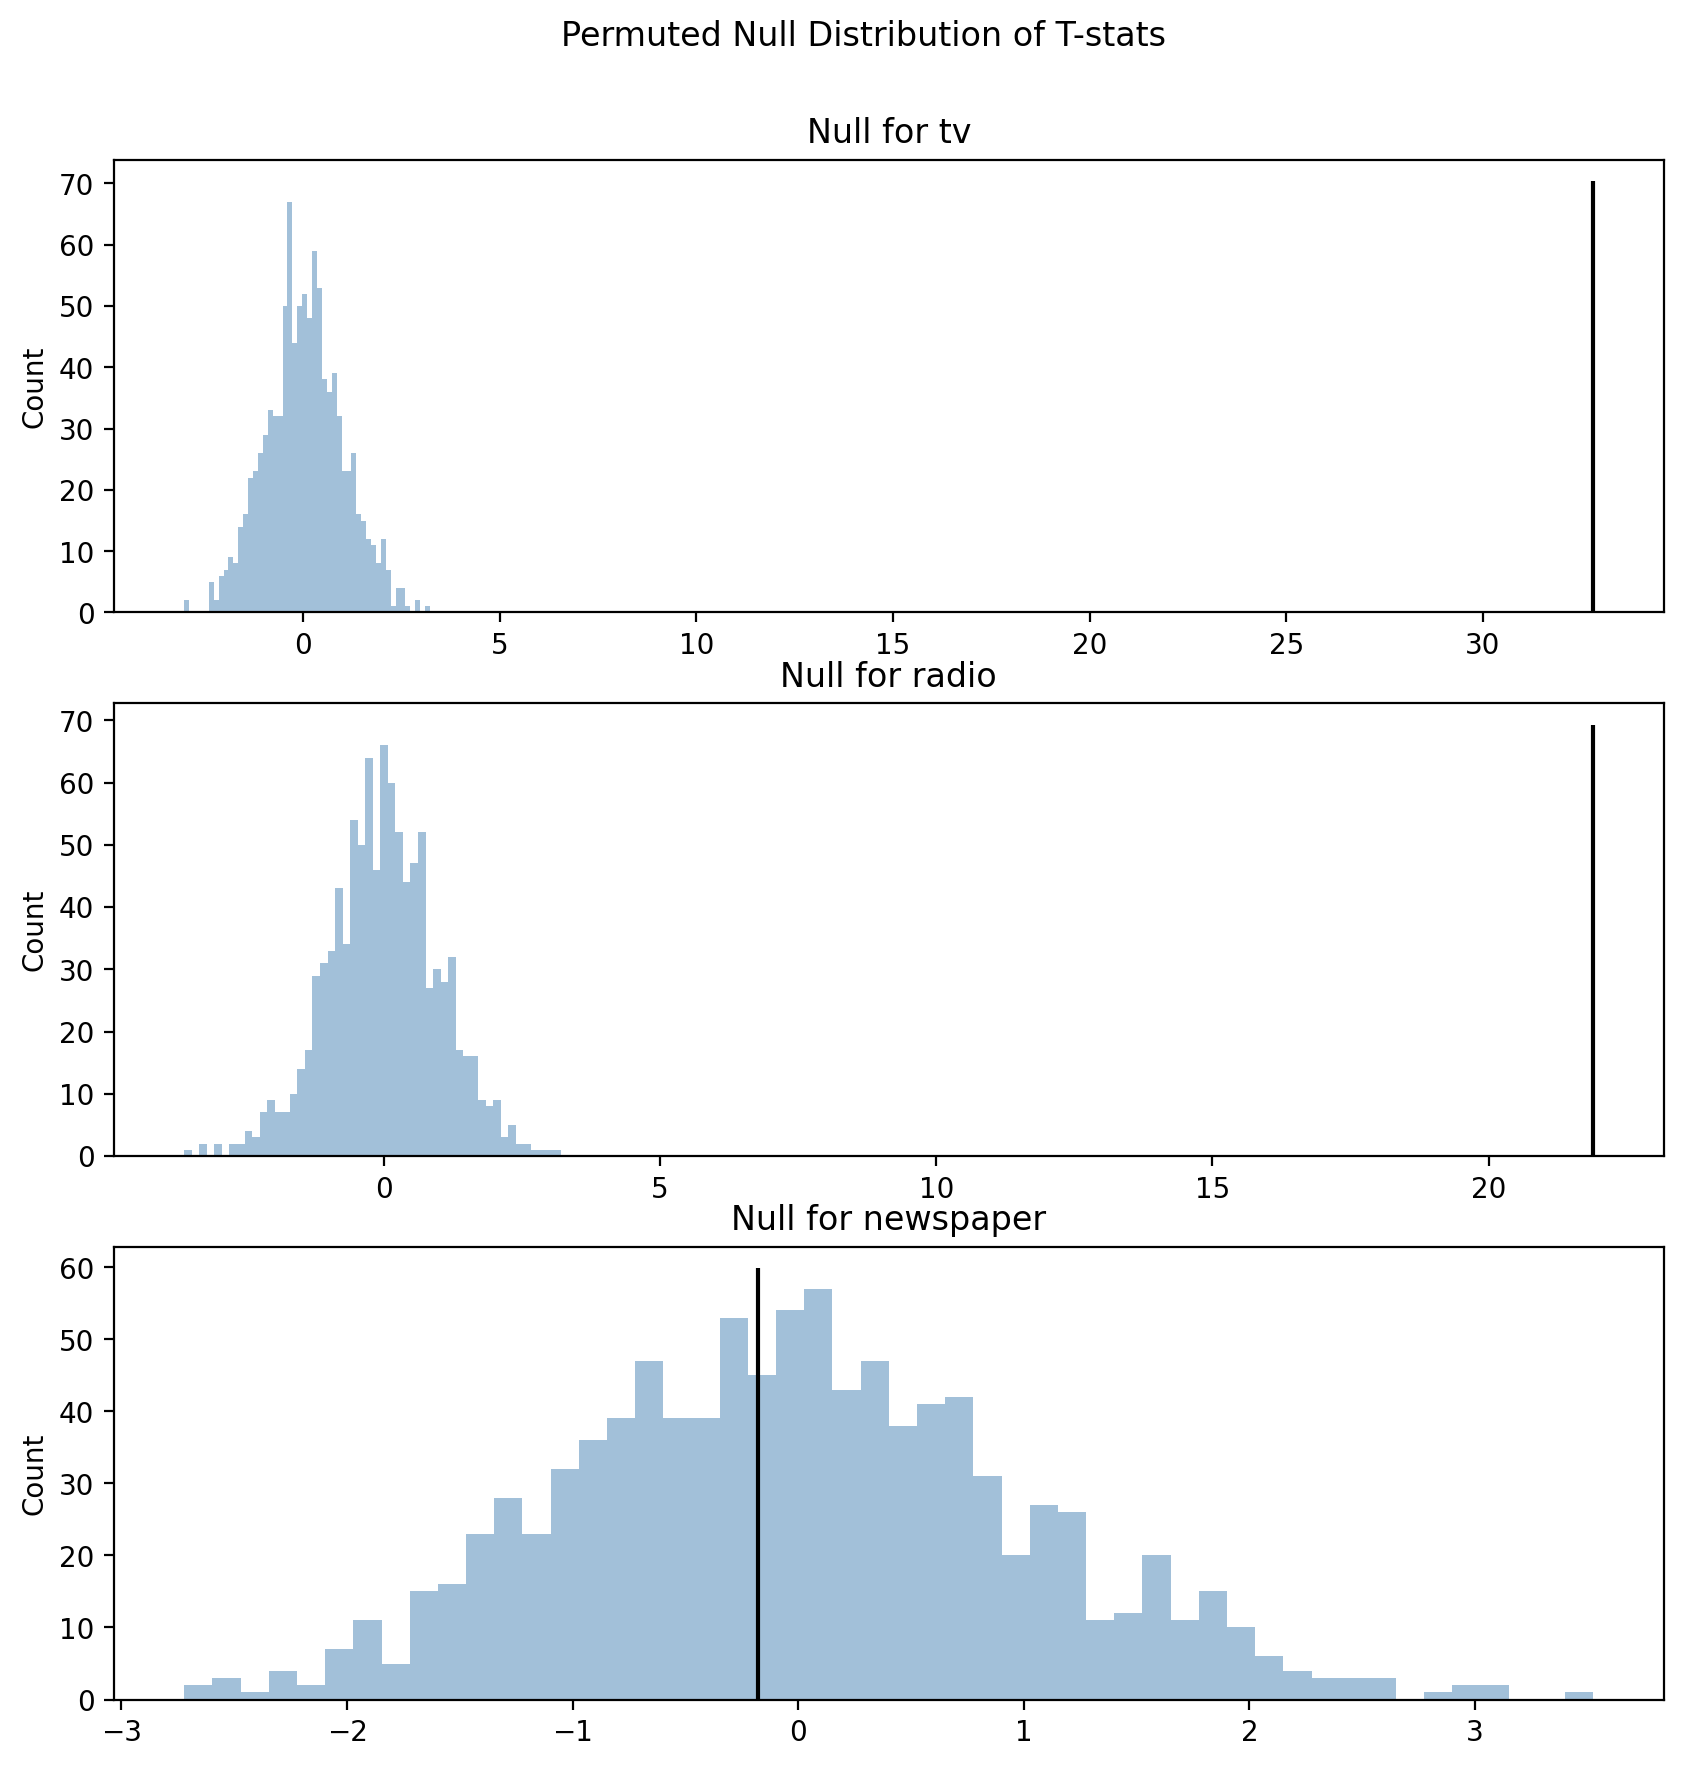

In [41]:
f, axs =plt.subplots(3,1, figsize=(10,10), sharey=False, sharex=False)
labels = ['tv', 'radio', 'newspaper']

for i, ax in enumerate(axs.flat):
    _ = ax.hist(perm_ts[:,i+1], bins=50, color='steelblue', alpha=0.5);
    _ = ax.set_title(f"Null for {labels[i]}");
    _ = ax.set_ylabel("Count");
    _ = ax.vlines(results.tvalues.to_numpy()[i+1], 0, ax.get_ylim()[-1], color='black', linestyle='-');

f.suptitle("Permuted Null Distribution of T-stats", y=.95);

It's very clear from these plots *why* $newspaper$ (bottom) is not "statistically significant" -

the signal-to-noise ratio $t$ is well-within the range of values we would expect assuming our data were random!

### Summary of non-parametric inference via permutation

- **Permutation** allows us to **build null distributions** to perform statistical inference on our parameter estimates 
- Based on how we choose *randomize* we can simulate the *specific* form of randomization that we what to make an inference about
- In the example above we *preserved the relationship between the predictors*, by *only* permuting the response variable
- To perform a permutation test with a GLM we can:
  1. Fit our model and calculate our *inferential statistic* - the one we want a p-value for $t$
  2. Shuffle our response variable $y$ and re-estimate our model using the shuffled data
  3. Repeat this process with more randomizations
  4. Calculate the proportion of times the *permuted* versions of our inferential statistic $t$ are greater-than-or-equal-to our observed value $t$ on the original data


## Challenge Q (response)

What do you think would happen if you instead shuffled a column of one of the *predictor* variables?


*Your response here*

## General summary of Non-Parametric Inference

With these two approach to resampling we can make **fewer assumptions** about the structure of our model's errors and just calculate them directly from our data. The biggest trade-off to these approaches is that they are more "expensive" to calculate - but when possible - especially with complicated datasets - they often yield more **robust** and **verifiable** inferences; when in doubt - just inspect the resampling or null distributions you created!

Regardless of whether you use parametric or non-parametric inference it's important to understand **why statistical signficance IS NOT practical or scientific significance.**

The standard-error and ultimately the t-stat and p-value reflect a combination of the following: 
- size of the $\beta$
- how bad the model is overall
- the sample size
- the variance of the $Xn$ that $\beta$ corresponds to
- and the correlation of $Xn$ with all other columns in $X$

To paraphrase from one of the assigned readings, [The Truth About Linear Regression](https://stat-intuitions.com/_downloads/f310e3f537dfd55cd52f36eb33e96313/TALR_23.pdf):

> This means that the standard errors will shrink as the sample size grows, so more and more variables will become significant as we get more data — but how much data we collect is irrelevant to how the process we’re studying actually works! Moreover, at a fixed sample size, the coefficients with smaller standard errors will tend to be the ones whose variables have more variance, and whose variables are less correlated with the other predictors. High input variance and low correlation help us estimate the coefficient precisely, but, again, they have *nothing* to do with whether the input variable actually influences the response a lot!

> To sum up, it is never the case that statistical significance is the same as scientific, real-world significance. The most important variables are not those with the largest-magnitude t statistics or smallest p-values. Statistical significance is always about what “signals” can be picked out clearly from background noise. In the case of linear regression coefficients, statistical significance runs together the size of the coefficients, how bad the linear regression model is, the sample size, the variance in the input variable, and the correlation of that variable with all the others. Of course, even the limited “does it help linear predictions enough to bother with?” utility of the usual t-test (and F-test) calculations goes away if the standard distributional assumptions do not hold, so that the calculated p-values are just wrong. But one can sometimes get away with using bootstrapping (Chapter 6) to get accurate p-values for standard tests under non-standard conditions


Paul Meehl noted the same dilemma if we use parametric inference as our only tool to perform Null-Hypothesis-Significance-Testing (NHST):  

In the limit of an *infinitely large sample size*, we have the *least* uncertainty (highest precision) to estimate a parameter. But counter-intuitively, that means that *any* non-zero estimate, **no matter how small** will appear "statistically significant" from 0 even if it's not practically meaningful!

[Meehl, P. E. (1967). Theory-Testing in Psychology and Physics: A Methodological Paradox. Philosophy of Science, 34(2), 103–115.](https://paperpile.com/shared/s1p5o~HBCTYirZk7U7GAuOg)

### Wrap-up
Let's wrap-up by writing a convenience function that "wraps" the 2 functions we wrote above. This will make it make this even easier to use we can tweak it so it feels like a drop-in replacement for `ols`:

We'll copy the definitions of our 2 function above inside the body of our new function and add a little bit of code to combine the outputs:


In [42]:
def ols_nonparam(formula, data, nsim=1000, random_seed=None, return_dists=False):
    """
    Non-parametric version of statsmodels OLS regression.
    Is equivalent to the output of ols(formula).fit() - in other words only returns
    the results not the model itself. The results also includes a .summary_resampled
    attribute that contains the bootstrapped and permuted results.

    Args:
        formula (str): formula to fit model
        data (DataFrame): pandas or polars DataFrame
        nsim (int, optional): number of bootstraps and permutations to run. Defaults to 1000.
        random_seed (int, optional): for reproducibility. Defaults to None.
        return_dists (bool, optional): whether to return the bootstrapped and permuted results. Defaults to False.

    Returns:
        results: statsmodels OLS regression results
    """

    from statsmodels.formula.api import ols

    # Create and fit the original model on the original data
    model = ols(formula, data)
    results = model.fit()

    # Define bootstrap function
    def boot_ols(results, nboot, random_seed):

        # A neat progress bar that replaces range()
        from tqdm import trange

        params = [] # to store the betas we estimate from each re-sampled dataset
        original_params = results.params.to_numpy() # the original betas for reference

        # For reproducibility
        np.random.seed(random_seed)

        # Start bootstrapping
        for _ in trange(nboot):
            
            # Resample with replacement - using pandas here instead of polars
            new_data = results.model.data.frame.sample(frac=1., replace=True)

            # Fit a new regression using this data and the original model formula
            boot_model = ols(results.model.formula, new_data).fit()

            # Save the estimated betas
            params.append(boot_model.params.to_numpy())
        
        # Convert the list to a numpy array for convenience
        params = np.array(params)

        # Calculate the width aka the standard-deviation across bootstraps
        std_devs = np.std(params, axis=0, ddof=results.df_model)

        # Calculate the signal-to-noise aka t-statistic using the bootstrapped SD
        tstats = original_params / std_devs 

        # Get the 95% CI limits using the bootstrapped estimates
        CI_limits = np.percentile(params, [2.5, 97.5], axis=0)

        # Combine into a DataFrame with original beta estimates
        boot_results = pl.DataFrame(CI_limits).transpose().with_columns(
            # Predictor names
            names = np.array(results.model.exog_names),
            # Bootstrapped SDs
            se=std_devs,
            # T-stats using boostrapped SDs
            tstats=tstats,
            # Original beta estimates
            estimate=original_params
            ).select(
                col('names').alias('variable'),
                col('estimate').alias('coef'),
                col('se').alias('boot-std'),
                col('tstats').alias('t'),
                col('column_0').alias('[0.025'),
                col('column_1').alias('0.975]'),
            )
        
        # Round to 5 decimal places
        boot_results = boot_results.select(
            col('variable'),
            pl.exclude("variable").round(5)
        )

        return boot_results, params

    # Define permutation function
    def perm_ols(results, nperm, random_seed):

        # A neat progress bar that replaces range()
        from tqdm import trange

        perm_ts = [] # to store the t-stats we estimate from each shuffled dataset
        original_ts = results.tvalues.to_numpy() # the original ts for reference
        dv_name = results.model.endog_names # name of y variable

        # For reproducibility
        np.random.seed(random_seed)

        for _ in trange(nperm):

            # Convert to polars for easier shuffling
            new_data = pl.DataFrame(data)
            new_data = new_data.with_columns(
                new_data[dv_name].sample(fraction=1.,with_replacement=False,shuffle=True)
                .alias(dv_name)
                )

            # Fit model to it; and convert back to pandas
            pmodel = ols(results.model.formula, data=new_data.to_pandas())
            presults = pmodel.fit()

            # Save the t-stats
            perm_ts.append(presults.tvalues.to_numpy())

        perm_ts = np.array(perm_ts)

        # Get the # of permuted t-stats >= observed t-stat
        proportion = np.sum(
            np.abs(perm_ts) >= np.abs(original_ts),
            axis=0) + 1   

        # Divide by number of permutation to get p-value
        # Add 1 to numerator and denominator to avoid divide-by-zero errors
        pvals = proportion / (nperm + 1)

        # Make a polars DataFrame
        pvals = pl.DataFrame(dict(zip(results.model.exog_names, pvals)))

        # Shuffling the data doesn't permute the intercept so ignore the p-value
        pvals[0, 'Intercept'] = np.nan

        # Return pvals and permuted t-stats
        return pvals, perm_ts
    
    # Run boostrapping and permuting
    boot_results, boot_betas = boot_ols(results, nsim, random_seed)
    pvals, perm_ts = perm_ols(results, nsim, random_seed)

    # Combine bootstrapped and permutation estimates into 1 DataFrame
    full_results = boot_results.with_columns(
        perm_p = pvals.to_numpy().flatten()

    )

    # Reorder columns to match ols output
    full_results = full_results.select(
        col('variable'),
        col('coef'),
        col('boot-std'),
        col('t'),
        col('perm_p').alias('P_perm>|t|'),
        col('[0.025'),
        col('0.975]')
    )

    # Attach to results object from ols
    results.summary_resampled = full_results

    # Return distributions of boostraps and permutation if requested
    if return_dists:
        return results, boot_betas, perm_ts
    else:
        return results

Let's try our function out! We can check-out the help we wrote:

In [43]:
ols_nonparam?

Signature:
ols_nonparam(
    formula,
    data,
    nsim=1000,
    random_seed=None,
    return_dists=False,
)
Docstring:
Non-parametric version of statsmodels OLS regression.
Is equivalent to the output of ols(formula).fit() - in other words only returns
the results not the model itself. The results also includes a .summary_resampled
attribute that contains the bootstrapped and permuted results.

Args:
    formula (str): formula to fit model
    data (DataFrame): pandas or polars DataFrame
    nsim (int, optional): number of bootstraps and permutations to run. Defaults to 1000.
    random_seed (int, optional): for reproducibility. Defaults to None.
    return_dists (bool, optional): whether to return the bootstrapped and permuted results. Defaults to False.

Returns:
    results: statsmodels OLS regression results
File:      /var/folders/4y/y26_jdm57m90f4s1td24ls040000gn/T/ipykernel_33472/992760803.py
Type:      function

And run it on our data:

In [44]:
results = ols_nonparam("sales ~ tv + radio + newspaper", data=df.to_pandas(), nsim=1000, random_seed=1)

100%|██████████| 1000/1000 [00:01<00:00, 531.94it/s]


We can access the non-parametric results via the `.summary_resampled` attribute of the output:

In [45]:
results.summary_resampled

variable,coef,boot-std,t,P_perm>|t|,[0.025,0.975]
str,f64,f64,f64,f64,f64,f64
"""Intercept""",2.93889,0.33699,8.7209,NaN,2.25649,3.57293
"""tv""",0.04576,0.00183,24.98447,0.000999,0.04215,0.04918
"""radio""",0.18853,0.01104,17.06964,0.000999,0.16665,0.20919
"""newspaper""",-0.00104,0.00675,-0.15363,0.87013,-0.01366,0.01226


And compare them to the parametric results that `ols` calculates for us:

In [46]:
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
No. Observations:                 200   F-statistic:                     570.3
Covariance Type:            nonrobust   Prob (F-statistic):           1.58e-96
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
tv             0.0458      0.001     32.809      0.000       0.043       0.049
radio          0.1885      0.009     21.893      0.000       0.172       0.206
newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now we have a quick way to checkout our non-parametric estimates alongside our parametric ones! For future assignments we'll try to include this function in a file that you can import. But it might be handy to refer to this notebook if you ever need to write it again.

## Challege: Non-Parametric Inference

Below we've loaded up Anscombe's Quartet again and plotted a simple univariate regression using `sns.lmplot`, which uses `ols` behind-the-scenes. 
When you run the cell you'll see the regression line for each dataset and 95% bootstrapped confidence intervals that seaborn automatically computed for us.

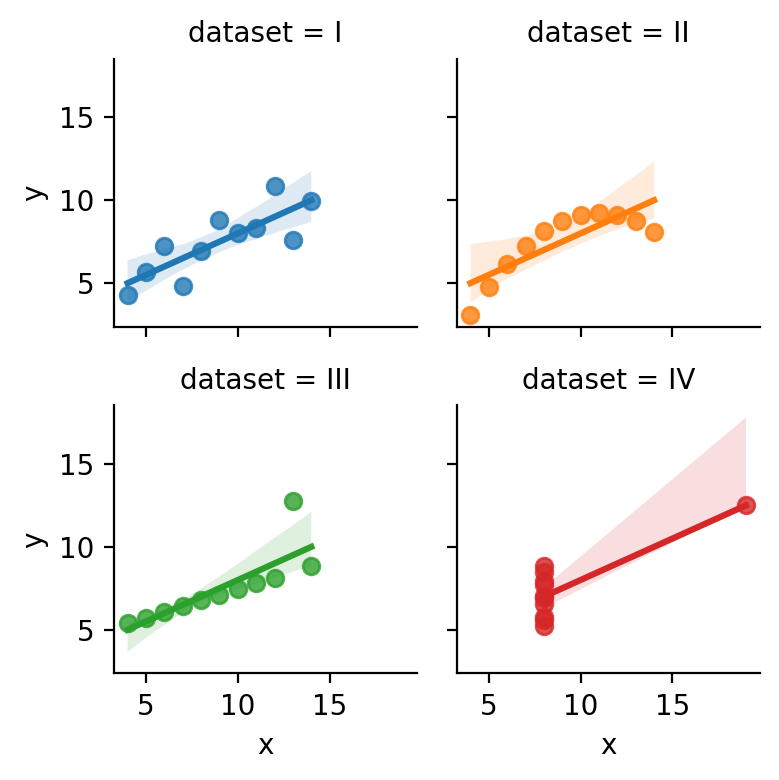

In [48]:
# Load and convert to polars
anscombe = pl.DataFrame(sns.load_dataset("anscombe")) 

# Plot the regression for each dataset separately
sns.lmplot(x="x", y="y", data=anscombe, hue="dataset", col='dataset', col_wrap=2, height=2)

Looking at each sub-plot above, it seems like the the "worst" fit is with **dataset IV**.

In every other dataset there seems to be *some* type of relationship between `x` and `y` - but in **dataset IV** this seems to be driven by a single observation. 

Your task is to fit a univariate regression to **dataset IV** only using the new `ols_nonparam` function we wrote.  
You'll have to use `.filter()` to subset the rows in `anscombe` that you want.

For `ols_nonparam` you can use:
- `nsim=2000`
- `random_seed=1`
- `return_dists=True`


In [51]:
# Solution
data_4 = anscombe.filter(col("dataset") == "IV")

In [52]:
# Solution
results, boots, perms = ols_nonparam('y ~ x', data=data_4.to_pandas(), nsim=2000,random_seed=1, return_dists=True)

100%|██████████| 2000/2000 [00:03<00:00, 617.38it/s]


Inspect the differences in the outputs of `.summary_resampled` and `.summary()`  
What do you notice?

In [53]:
# Solution
results.summary_resampled
results.summary(slim=True)

variable,coef,boot-std,t,P_perm>|t|,[0.025,0.975]
str,f64,f64,f64,f64,f64,f64
"""Intercept""",3.00173,1.48395,2.02279,NaN,0.10001,4.12477
"""x""",0.49991,0.17794,2.80946,0.064468,0.4408,0.92688


/Users/esh/miniconda3/envs/201b/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  return hypotest_fun_in(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.630
No. Observations:                  11   F-statistic:                     18.00
Covariance Type:            nonrobust   Prob (F-statistic):            0.00216
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0017      1.124      2.671      0.026       0.459       5.544
x              0.4999      0.118      4.243      0.002       0.233       0.766
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Inspect `perms` using a histogram.  
*You can use `perms = perm[:, 1]` before plotting to only plot the permuted values for `x` and ignore the model intercept*  

What do you notice? How does this affect the permuted p-value vs the analytic p-value in the outputs above?

In [54]:
# Solution
# Ignore intercept
perms = perms[:, 1]

(array([372., 182., 168., 351., 170., 196., 371.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 190.]),
 array([-1.18601317, -0.9145611 , -0.64310903, -0.37165696, -0.1002049 ,
         0.17124717,  0.44269924,  0.71415131,  0.98560337,  1.25705544,
         1.52850751,  1.79995958,  2.07141165,  2.34286371,  2.61431578,
         2.88576785,  3.15721992,  3.42867199,  3.70012405,  3.97157612,
         4.24302819]),
 <BarContainer object of 20 artists>)

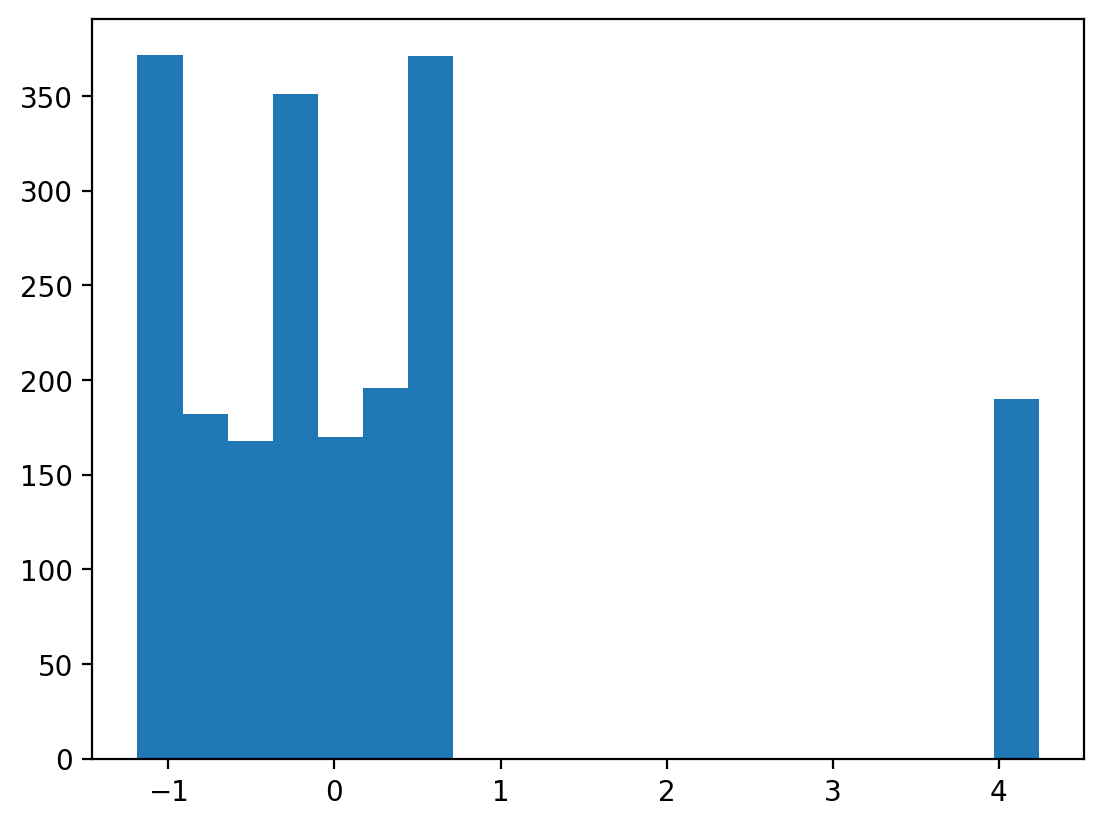

In [55]:
plt.hist(perms, bins=20)